In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.misc
from scipy import ndimage
import matplotlib.pyplot as plt

import pandas as pd

### Parámetros de Mallado

In [2]:
### RECORREMOS UNA PROFUNDIDAD

dz = 0.01e-6 ## Paso en Profundidad  nm
start_z = 0
stop_z = 1e-6

### PARA LA SUPERFICIE X-Y
dy = 0.25e-6  ## Paso en Superficie um
start_y = -15e-6
stop_y = 15e-6

dx = 0.25e-6  ## Paso en Superficie um
start_x = -15e-6
stop_x = 15e-6

### EN UN TIEMPO 
dt = 10e-15  ## Time Step fs
start_t = 0
stop_t = 5e-12 ## Finalizamos a ps


x = np.linspace(start_x,stop_x,int(round((stop_x-start_x)/dx)))
y = np.linspace(start_y,stop_y,int(round((stop_y-start_y)/dy)))
z = np.linspace(start_z,stop_z,int(round((stop_z-start_z)/dz)))
t = np.linspace(start_t,stop_t,int(round((stop_t-start_t)/dt)))

X,Y,Z,tt= np.meshgrid(x,y,z,t)

## Auxiliar para Plot X-Z en punto medio de Y
y_mid = y.shape[0]//2

In [3]:
# ------------- Red Electrones -----------------
Ce_aux = 134.5 # J / (m^3 K^2)
ke = 235  # J /(m K s)
g = 5.69e17 # J /(m K^3 s)

#  ----------------------------------------------

# ------------- Red Lattice -----------------
Ci = 2.42e6  # J / (m^3 K)
#  -------------------------------------------


# ------------- Parámetros Láser -----------------
R = 0.88 # Reflectancia A.U.
delta = 20e-9 # Optical Penetration (nm)
ball_len = 100e-9 # Ballistic Length (nm)
 
tp = 100e-15 # FWHM fs
w0 = 5e-6 # Waist um
wavelength = 1.032e-6 # Wavelength (um)
#  ------------------------------------------------------

# ------------- Parámetros Varios -----------------
ys = 3e-6 ## Perfil de Apertura del Láser (um)
T0 = 300 # K Temperatura Ambiente (K)
x0 = 0 # Posición central del Spot en x
y0 = 0 # Posición central del Spot en y
zs = 0 # Z superficial
n = 1 ## Refractive Index
Zr = n*np.pi*w0**2/wavelength
w = w0*(1+Z**2/Zr**2)**1/2

### PARAMETRO A OPTIMIZAR

In [4]:
F = 2.5*1e4 # Fluence J/cm^2 -> J/m^2

In [5]:
### Cálculos de la Fuente Laser 
    # Q(x,y,z,t) = T(t) * S(x,y,z)

T = 1/tp * np.sqrt(4 * np.log(2)/np.pi) * np.exp(
-4*np.log(2) * ((t - 2*tp)/tp)**2)

S = (1-R)/(delta + ball_len) * F * np.exp(
-(Z-zs)/(delta+ball_len) - (2*(X-x0)**2 + 2*(Y-y0)**2)/w**2)


Q = S*T
print(f"Q Shape: {Q.shape}")
### Temperaturas para t0
Te = np.ones_like(Q[:,:,:,0])*300
Ti = np.ones_like(Q[:,:,:,0])*300

Tenew,Tinew = np.zeros_like(Te), np.zeros_like(Ti)

### Parametro Auxiliar
s = dt/Ce_aux

Q Shape: (120, 120, 100, 500)


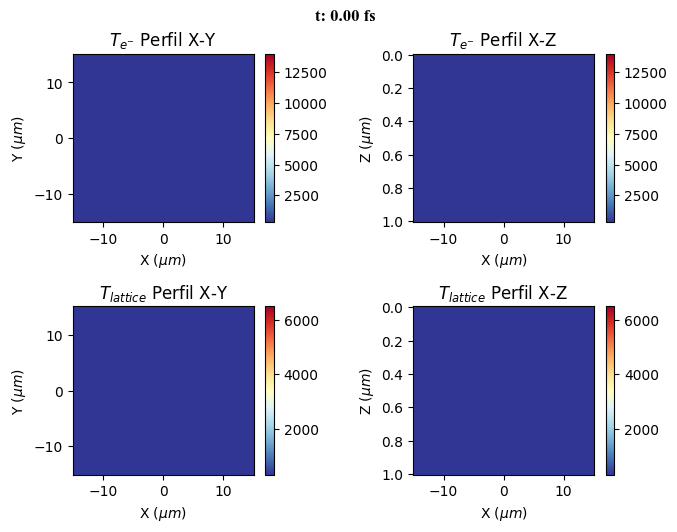

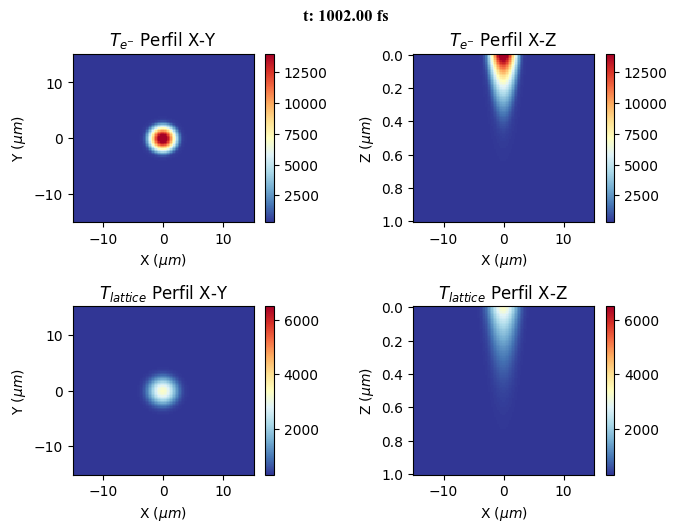

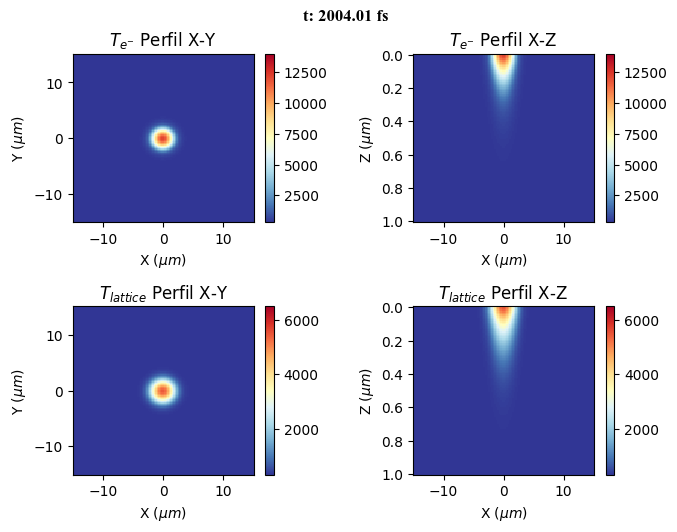

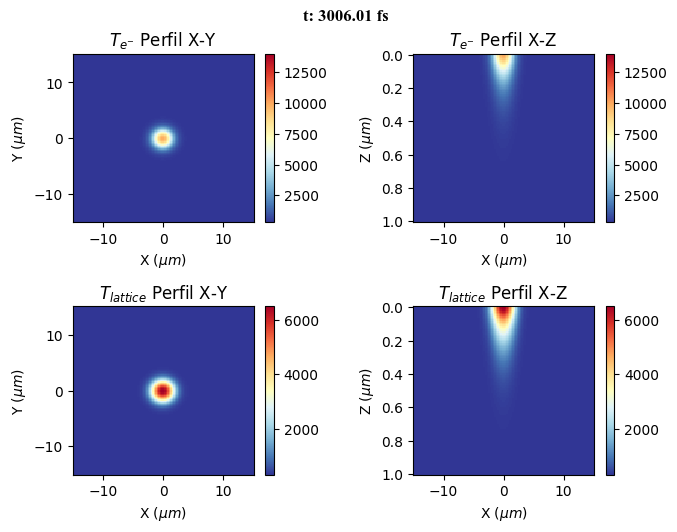

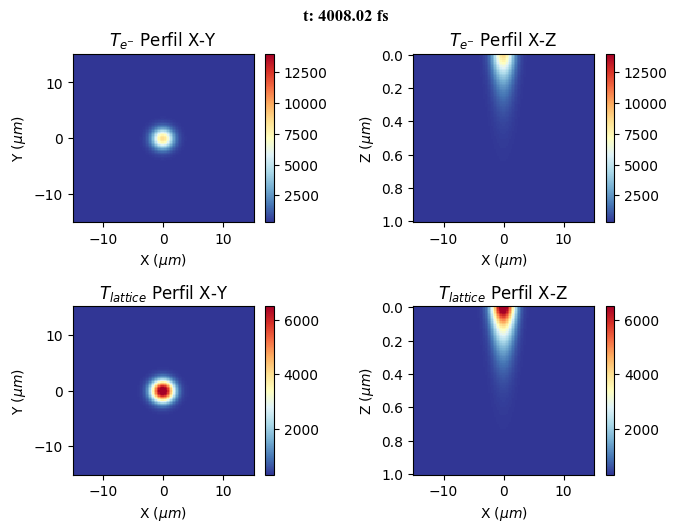

In [ ]:
for n in range(0,len(t)-1):
    for i in range(1,len(x)-1):
        for j in range(1,len(y)-1):
            for k in range(1,len(z)-1):
                Tenew[i,j,k] = Te[i,j,k] + s/Te[i,j,k]*(
                    ke*((Te[i+1,j,k] - 2 * Te[i,j,k] + Te[i-1,j,k])/dx/dx + (Te[i,j+1,k] - 2* Te[i,j,k] + Te[i,j-1,k])/dy/dy + (Te[i,j,k+1] -2*Te[i,j,k] + Te[i,j,k-1])/dz/dz)) - (
                    s/Te[i,j,k]*g*(Te[i,j,k]-Ti[i,j,k])) + s/Te[i,j,k]*Q[i,j,k,n]
            
                Tinew[i,j,k] = Ti[i,j,k] + dt/Ci * g * (Te[i,j,k] - Ti[i,j,k])
            
    ### CONDICIONES DE CONTORNO
    Tenew[0,:,:], Tenew[-1,:,:], Tenew[:,0,:], Tenew[:,-1,:], Tenew[:,:,0], Tenew[:,:,-1] = Tenew[1,:,:], Tenew[-2,:,:], Tenew[:,1,:], Tenew[:,-2,:], Tenew[:,:,1], Tenew[:,:,-2]
    Tinew[0,:,:], Tinew[-1,:,:], Tinew[:,0,:], Tinew[:,-1,:], Tinew[:,:,0], Tinew[:,:,-1] = Tinew[1,:,:], Tinew[-2,:,:], Tinew[:,1,:], Tinew[:,-2,:], Tinew[:,:,1], Tinew[:,:,-2]
    Te = Tenew
    Ti = Tinew
    
    if (n%100 == 0):
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
        plt.gca().invert_yaxis()
        fig.tight_layout()
        
        fig.subplots_adjust(hspace=0.5,wspace=0.5)
        fig.suptitle(f't: {t[n]*1e15:.2f} fs',y = 1.05,fontname="Times New Roman", fontweight="bold")
        im1 = ax1.pcolor(X[:,:,0,n]*1e6,Y[:,:,0,n]*1e6,Te[:,:,0],vmin = 300,vmax = 14000,cmap="RdYlBu_r",)
        fig.colorbar(im1)
        ax1.set_title("$T_{e^{-}}$ Perfil X-Y ")
        ax1.set_xlabel("X ($\mu m$)")
        ax1.set_ylabel("Y ($\mu m$)")
        
        
        im2 = ax2.pcolor(X[y_mid,:,:,n]*1e6,Z[y_mid,:,:,n]*1e6,Te[y_mid,:,:],vmin = 300,vmax = 14000,cmap="RdYlBu_r",)
        fig.colorbar(im2)
        ax2.invert_yaxis()
        ax2.set_title("$T_{e^{-}}$ Perfil X-Z ")
        ax2.set_xlabel("X ($\mu m$)")
        ax2.set_ylabel("Z ($\mu m$)")
        
        im3 = ax3.pcolor(X[:,:,0,n]*1e6,Y[:,:,0,n]*1e6,Ti[:,:,0],vmin = 300,vmax = 6500,cmap="RdYlBu_r",)
        fig.colorbar(im3)
        ax3.set_title("$T_{lattice}$ Perfil X-Y ")
        ax3.set_xlabel("X ($\mu m$)")
        ax3.set_ylabel("Y ($\mu m$)")
        
        im4 = ax4.pcolor(X[y_mid,:,:,n]*1e6,Z[y_mid,:,:,n]*1e6,Ti[y_mid,:,:],vmin = 300,vmax = 6500,cmap="RdYlBu_r",)
        fig.colorbar(im4)
        ax4.set_title("$T_{lattice}$ Perfil X-Z ")
        ax4.set_xlabel("X ($\mu m$)")
        ax4.set_ylabel("Z ($\mu m$)")

        for ax in fig.get_axes():
            ax.label_outer()
            
        plt.show()
        
np.save(f"Tred_{F/1e4:.1f}J_cm2",Ti)

### Guardamos Valores
Guardamos la Temperatura de la Red para los 5 ps

In [ ]:
np.save(f"Tred_{F/1e4:.1f}J_cm2",Ti)